In [101]:
import os
import sys
import json
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [102]:
@dataclass
class BarData:
    total_time: float
    trace_time_ratio: float
    tlas_percent: float

In [103]:
class GraphData:
    def __init__(self):
        # str -> BarData
        self.times = {}
    
    def add_data(self, render_type: str, data):
        if render_type not in self.times:
            self.times[render_type] = BarData(total_time=0.0, trace_time_ratio=0, tlas_percent=0.0)

        avg_total_time = data['avg_total_time']

        if 'RT' in render_type:
            if 'tlas_percent' in data:
                self.times[render_type].tlas_percent = data['tlas_percent']
            else:
                self.times[render_type].trace_time_ratio = data['avg_trace_time_ratio']
                self.times[render_type].total_time = avg_total_time
        else:
            self.times[render_type].total_time = avg_total_time
        

In [104]:
class ResolutionData:
    def __init__(self):
        self.graphs_data = {}

    def add_data(self, render_type: str, num_views: int, data):
        if num_views not in self.graphs_data:
            self.graphs_data[num_views] = GraphData()

        self.graphs_data[num_views].add_data(render_type, data)

In [105]:
class EnvironmentData:
    def __init__(self, name: str):
        # One set of graphs per resolution
        self.resolutions_data = {}
        self.env_name = name

    # data is parsed JSON
    def add_data(self, render_type: str, num_views: int, resolution: int, data):
        if resolution not in self.resolutions_data:
            self.resolutions_data[resolution] = ResolutionData()

        self.resolutions_data[resolution].add_data(render_type, num_views, data)

In [106]:
def make_env_data(env_dir):
    stat_files = os.listdir(env_dir)

    # We are going to generate a graph per resolution per environment
    env_data = EnvironmentData(name=env_dir)

    for file_name in stat_files:
        name_components = file_name.split('.')[0].split('_')

        render_type = name_components[1]
        num_views = int(name_components[2])
        resolution_str = name_components[3]

        resolution_num = int(resolution_str.split('x')[0])

        with open(env_dir + '/' + file_name, 'r') as file:
            data = json.load(file)
            env_data.add_data(render_type, num_views, resolution_num, data)
            
    return env_data

In [107]:
# Generate and show the graph
def gen_time_graphs(env_data, num_views_per_world=1):
    num_resolutions = len(env_data.resolutions_data)
    num_view_counts = len(list(env_data.resolutions_data.values())[0].graphs_data)

    fig, axs = plt.subplots(num_view_counts, num_resolutions, figsize=(18, 14))

    sorted_res_keys = list(env_data.resolutions_data.keys())
    sorted_res_keys.sort()

    res_counter = 0

    max_time_value = 0

    for res in sorted_res_keys:
        resolution_data = env_data.resolutions_data[res]

        sorted_num_views = list(resolution_data.graphs_data.keys())
        sorted_num_views.sort()

        num_views_counter = 0

        for num_views in sorted_num_views:
            graph_data = resolution_data.graphs_data[num_views]

            sorted_render_modes = list(graph_data.times.keys())
            sorted_render_modes.sort()

            x = []

            # Use the y build time as the raster's render time
            y_build_time = []
            y_tlas_time = []
            y_blas_time = []

            actual_num_views = num_views * num_views_per_world

            for render_mode in sorted_render_modes:
                x.append(render_mode)

                bar_data = graph_data.times[render_mode]

                max_time_value = max(max_time_value, bar_data.total_time)

                if 'Rast' in render_mode:
                    y_build_time.append(bar_data.total_time)
                    y_tlas_time.append(0.0)
                    y_blas_time.append(0.0)
                else:
                    trace_percent = bar_data.trace_time_ratio
                    tlas_percent = bar_data.tlas_percent

                    build_time = (1.0 - trace_percent) * bar_data.total_time
                    tlas_time = tlas_percent * trace_percent * bar_data.total_time
                    blas_time = (1.0 - tlas_percent) * trace_percent * bar_data.total_time

                    y_build_time.append(build_time)
                    y_tlas_time.append(tlas_time)
                    y_blas_time.append(blas_time)


            axs[num_views_counter, res_counter].bar(x, y_build_time)
            axs[num_views_counter, res_counter].bar(x, y_blas_time, bottom=y_build_time)
            axs[num_views_counter, res_counter].bar(x, y_tlas_time, bottom=[i+j for i, j in zip(y_build_time, y_blas_time)])

            axs[num_views_counter, res_counter].set_title(f'{env_data.env_name}; {actual_num_views} views; {res}x{res}')
            num_views_counter += 1

        res_counter += 1

    res_counter = 0
    for res in sorted_res_keys:
        num_views_counter = 0

        for num_views in sorted_num_views:
            axs[num_views_counter, res_counter].set_ylim(0, max_time_value)
            num_views_counter = num_views_counter + 1

        res_counter = res_counter + 1

    plt.tight_layout()
    plt.savefig(env_data.env_name + '.png')
    plt.show()

In [108]:
def gen_fps_graphs(env_data, num_views_per_world=1):
    num_resolutions = len(env_data.resolutions_data)
    num_view_counts = len(list(env_data.resolutions_data.values())[0].graphs_data)

    fig, axs = plt.subplots(num_view_counts, num_resolutions, figsize=(20, 17))

    sorted_res_keys = list(env_data.resolutions_data.keys())
    sorted_res_keys.sort()

    res_counter = 0

    for res in sorted_res_keys:
        resolution_data = env_data.resolutions_data[res]

        sorted_num_views = list(resolution_data.graphs_data.keys())
        sorted_num_views.sort()

        num_views_counter = 0

        for num_views in sorted_num_views:
            graph_data = resolution_data.graphs_data[num_views]

            sorted_render_modes = list(graph_data.times.keys())
            sorted_render_modes.sort()

            x = []

            # Use the y as the FPS
            y_fps = []

            actual_num_views = num_views * num_views_per_world

            for render_mode in sorted_render_modes:
                x.append(render_mode)

                total_time = graph_data.times[render_mode].total_time

                fps = float(actual_num_views) / (0.001 * total_time)
                y_fps.append(fps)


            axs[num_views_counter, res_counter].bar(x, y_fps)

            axs[num_views_counter, res_counter].set_title(f'{env_data.env_name}; {actual_num_views} views; {res}x{res}')
            num_views_counter += 1

        res_counter += 1

    plt.tight_layout()
    # plt.savefig(env_data.env_name + '.png')
    plt.show()

In [109]:
env0_data = make_env_data("env0")
env1_data = make_env_data("env1")
env2_data = make_env_data("env2")
hideseek_data = make_env_data("hideseek")

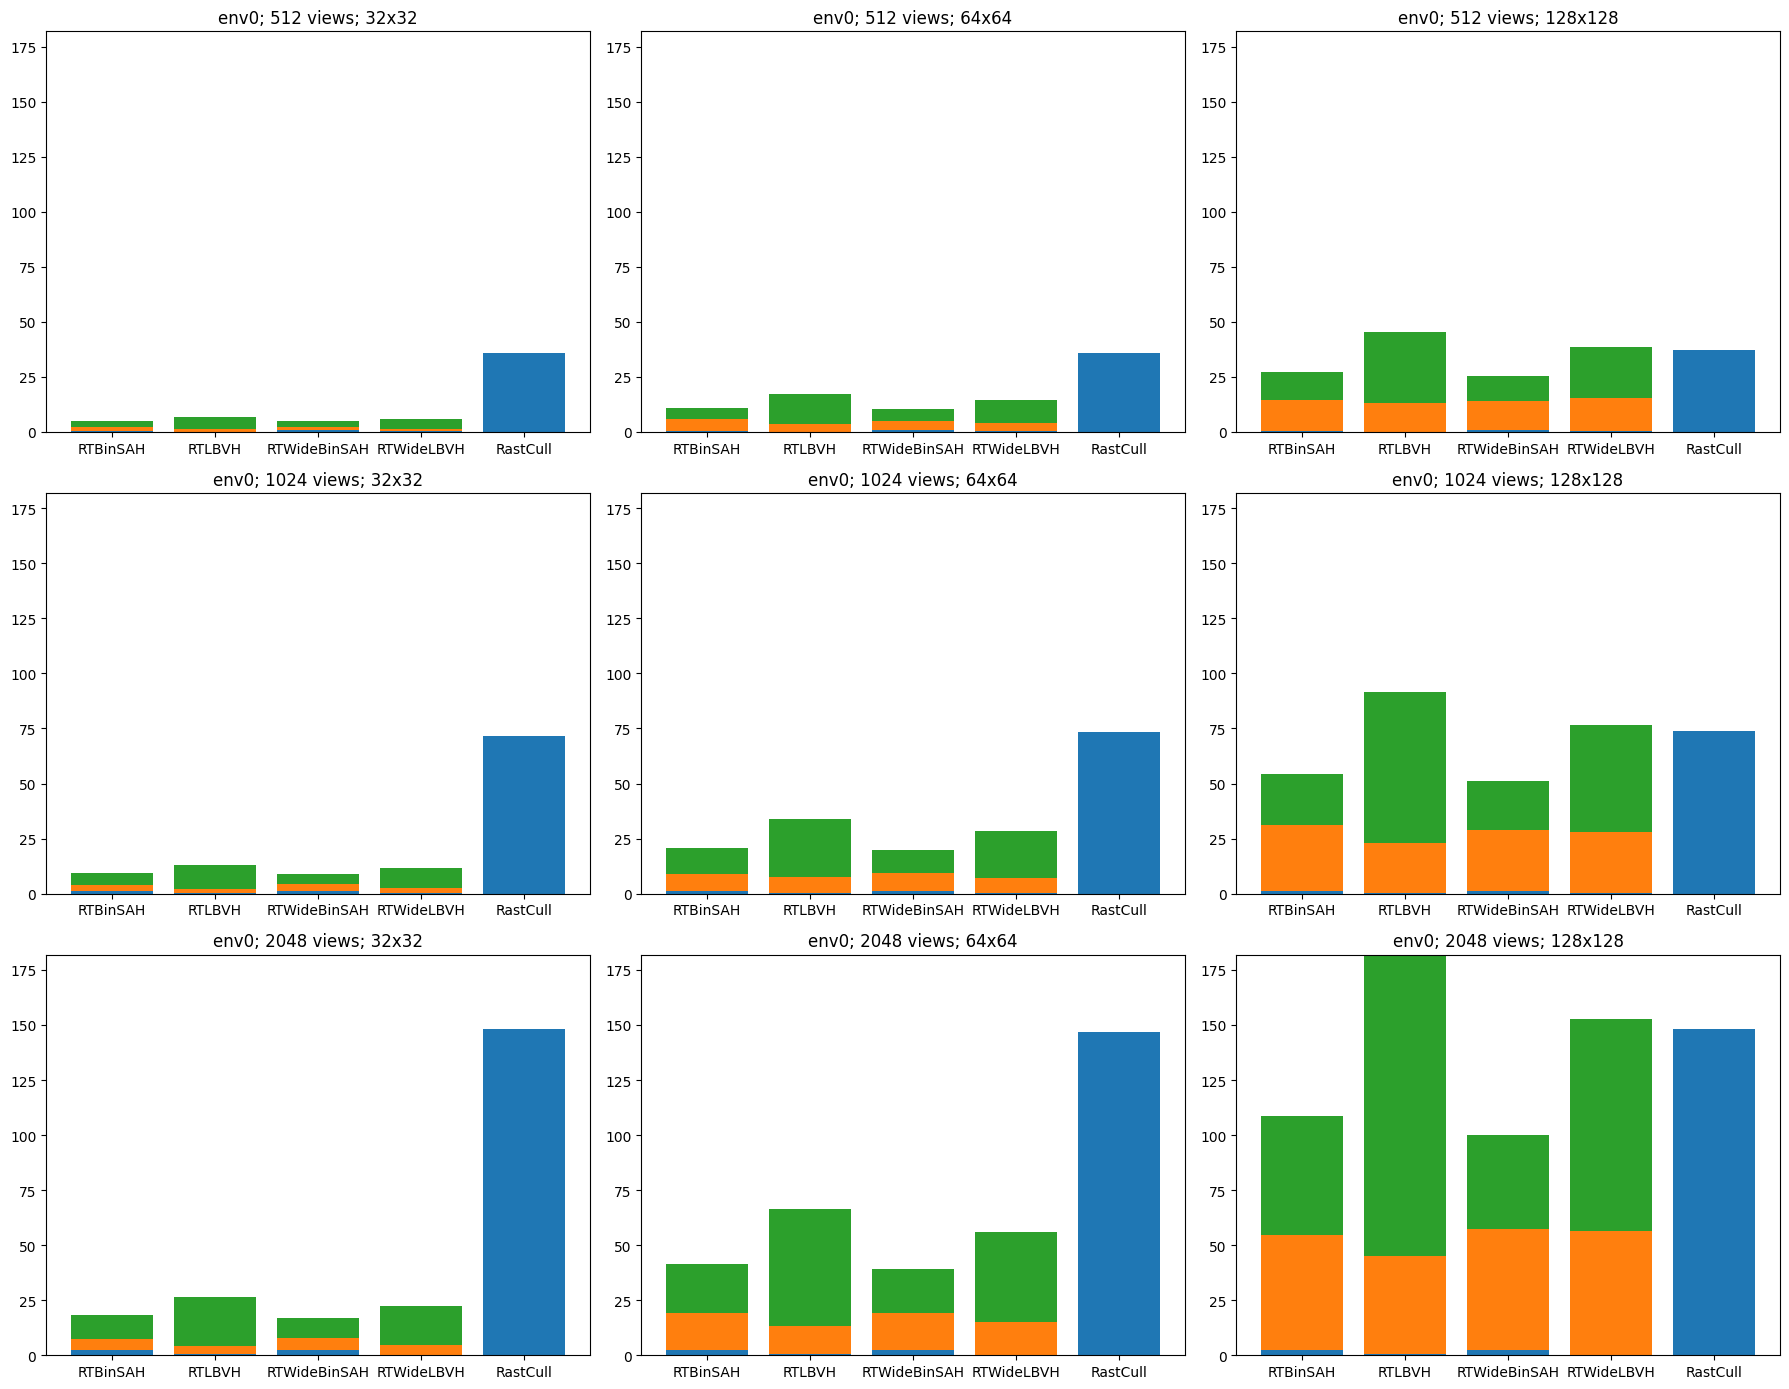

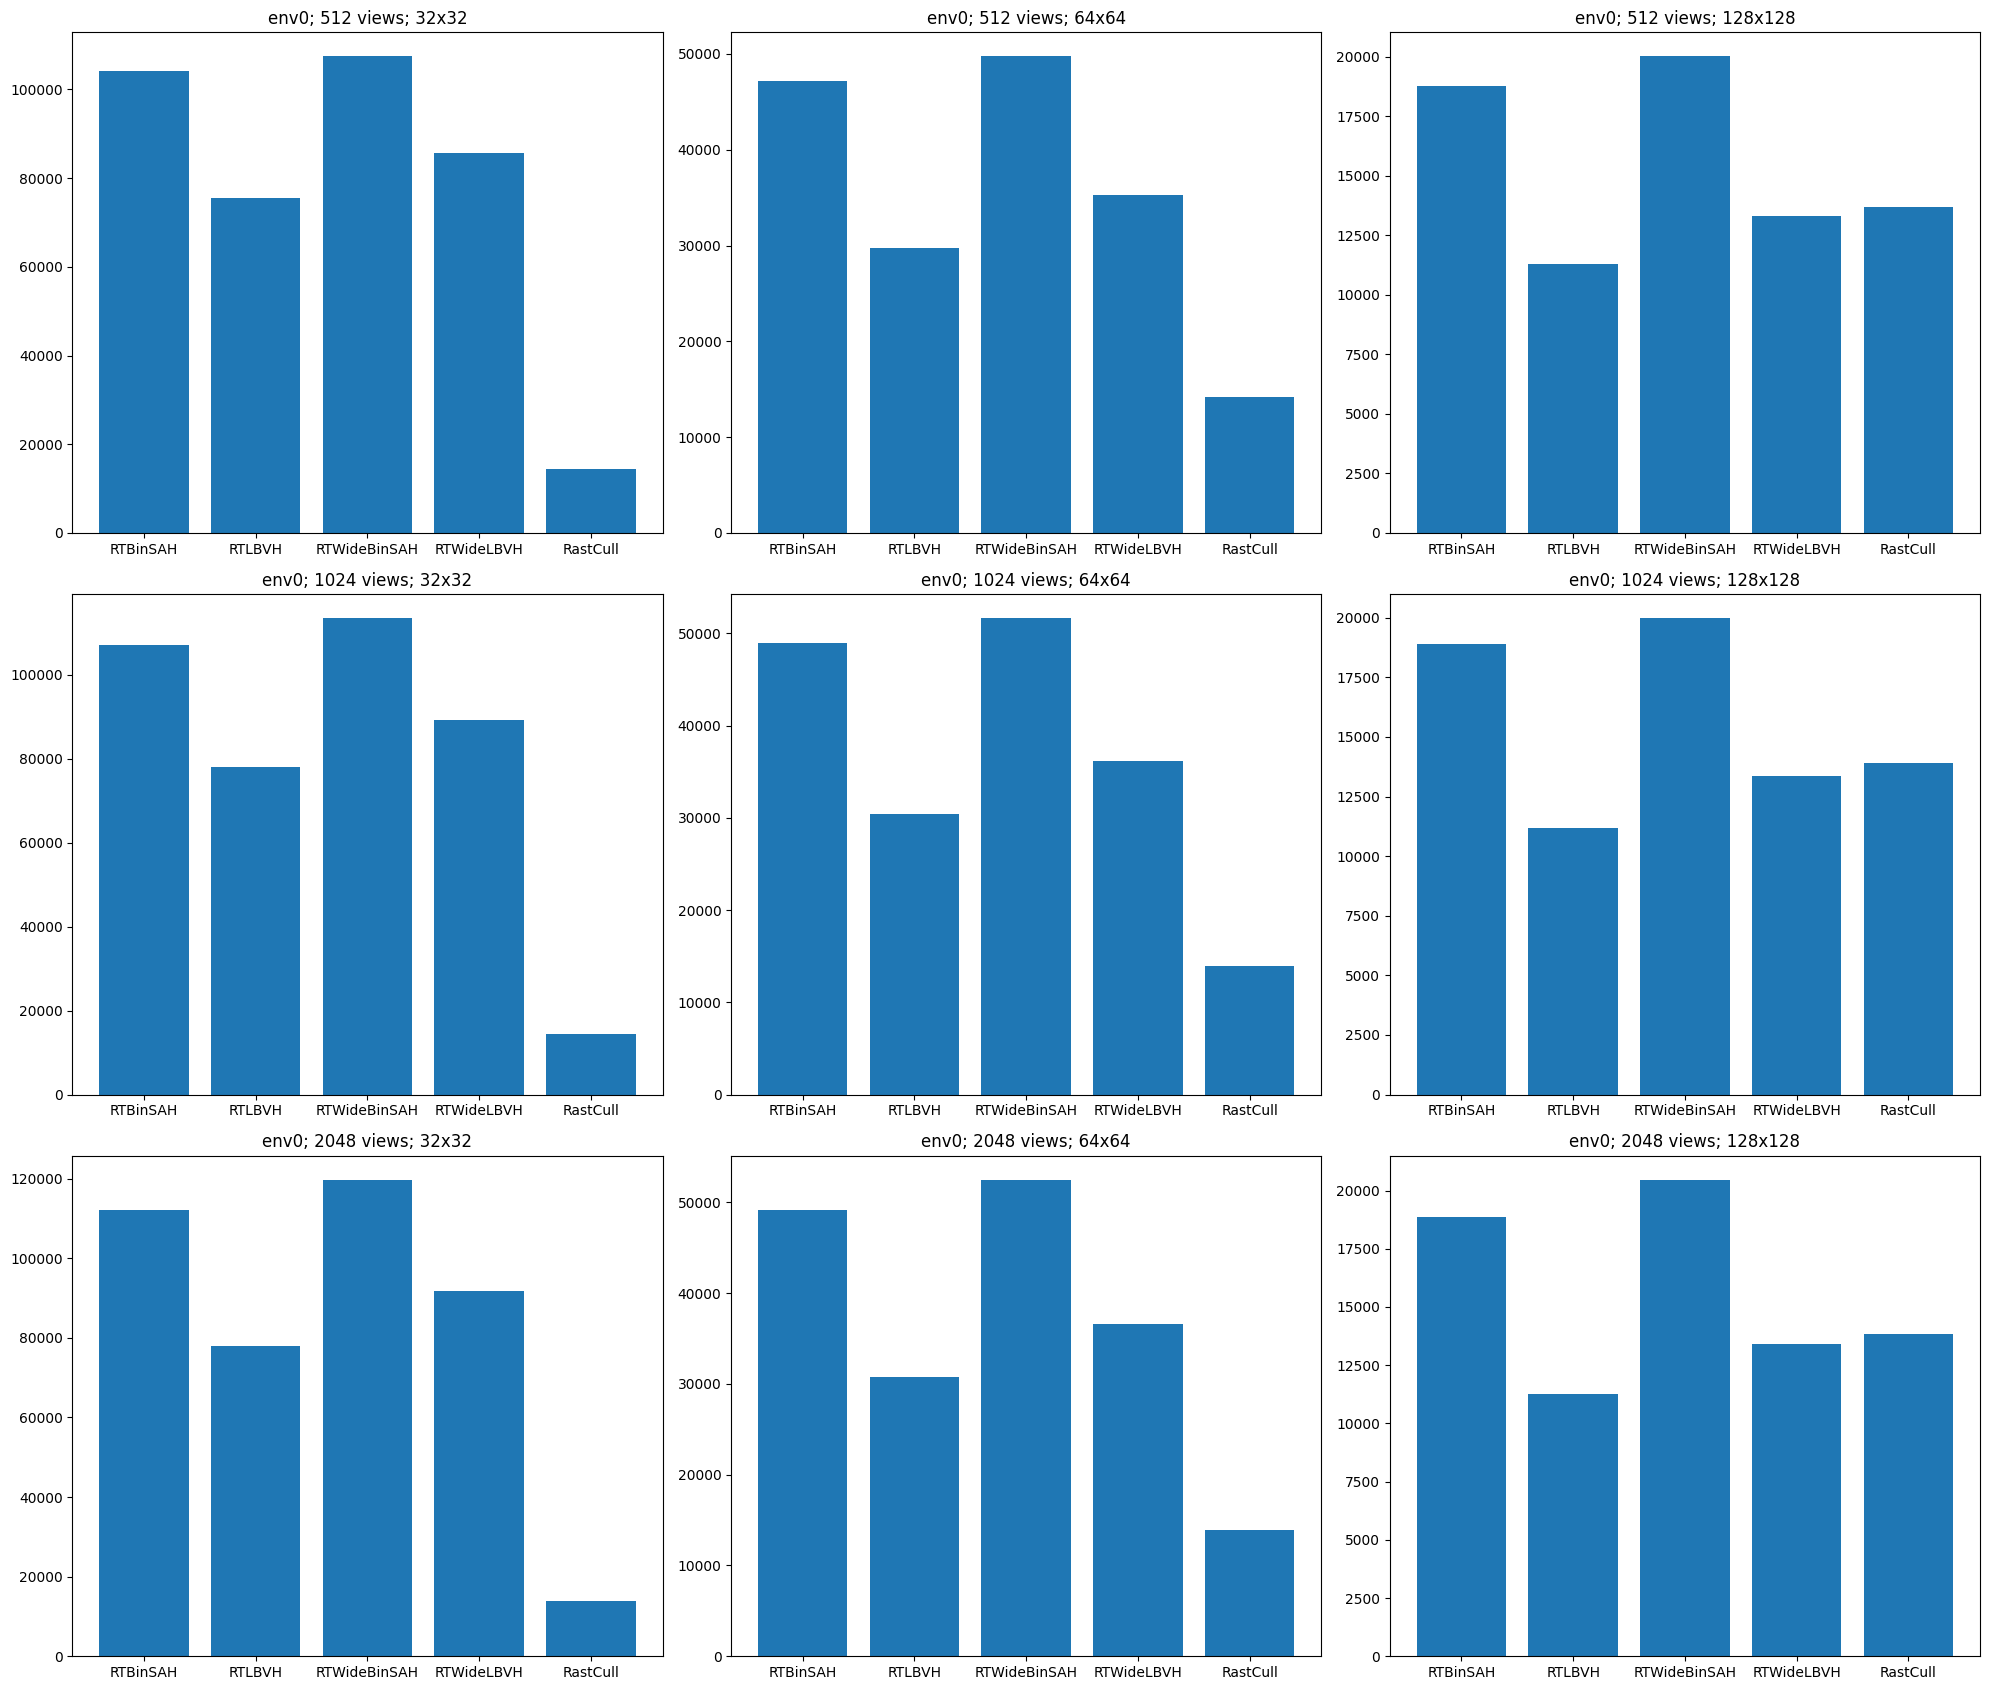

In [110]:
gen_time_graphs(env0_data, 1)
gen_fps_graphs(env0_data, 1)

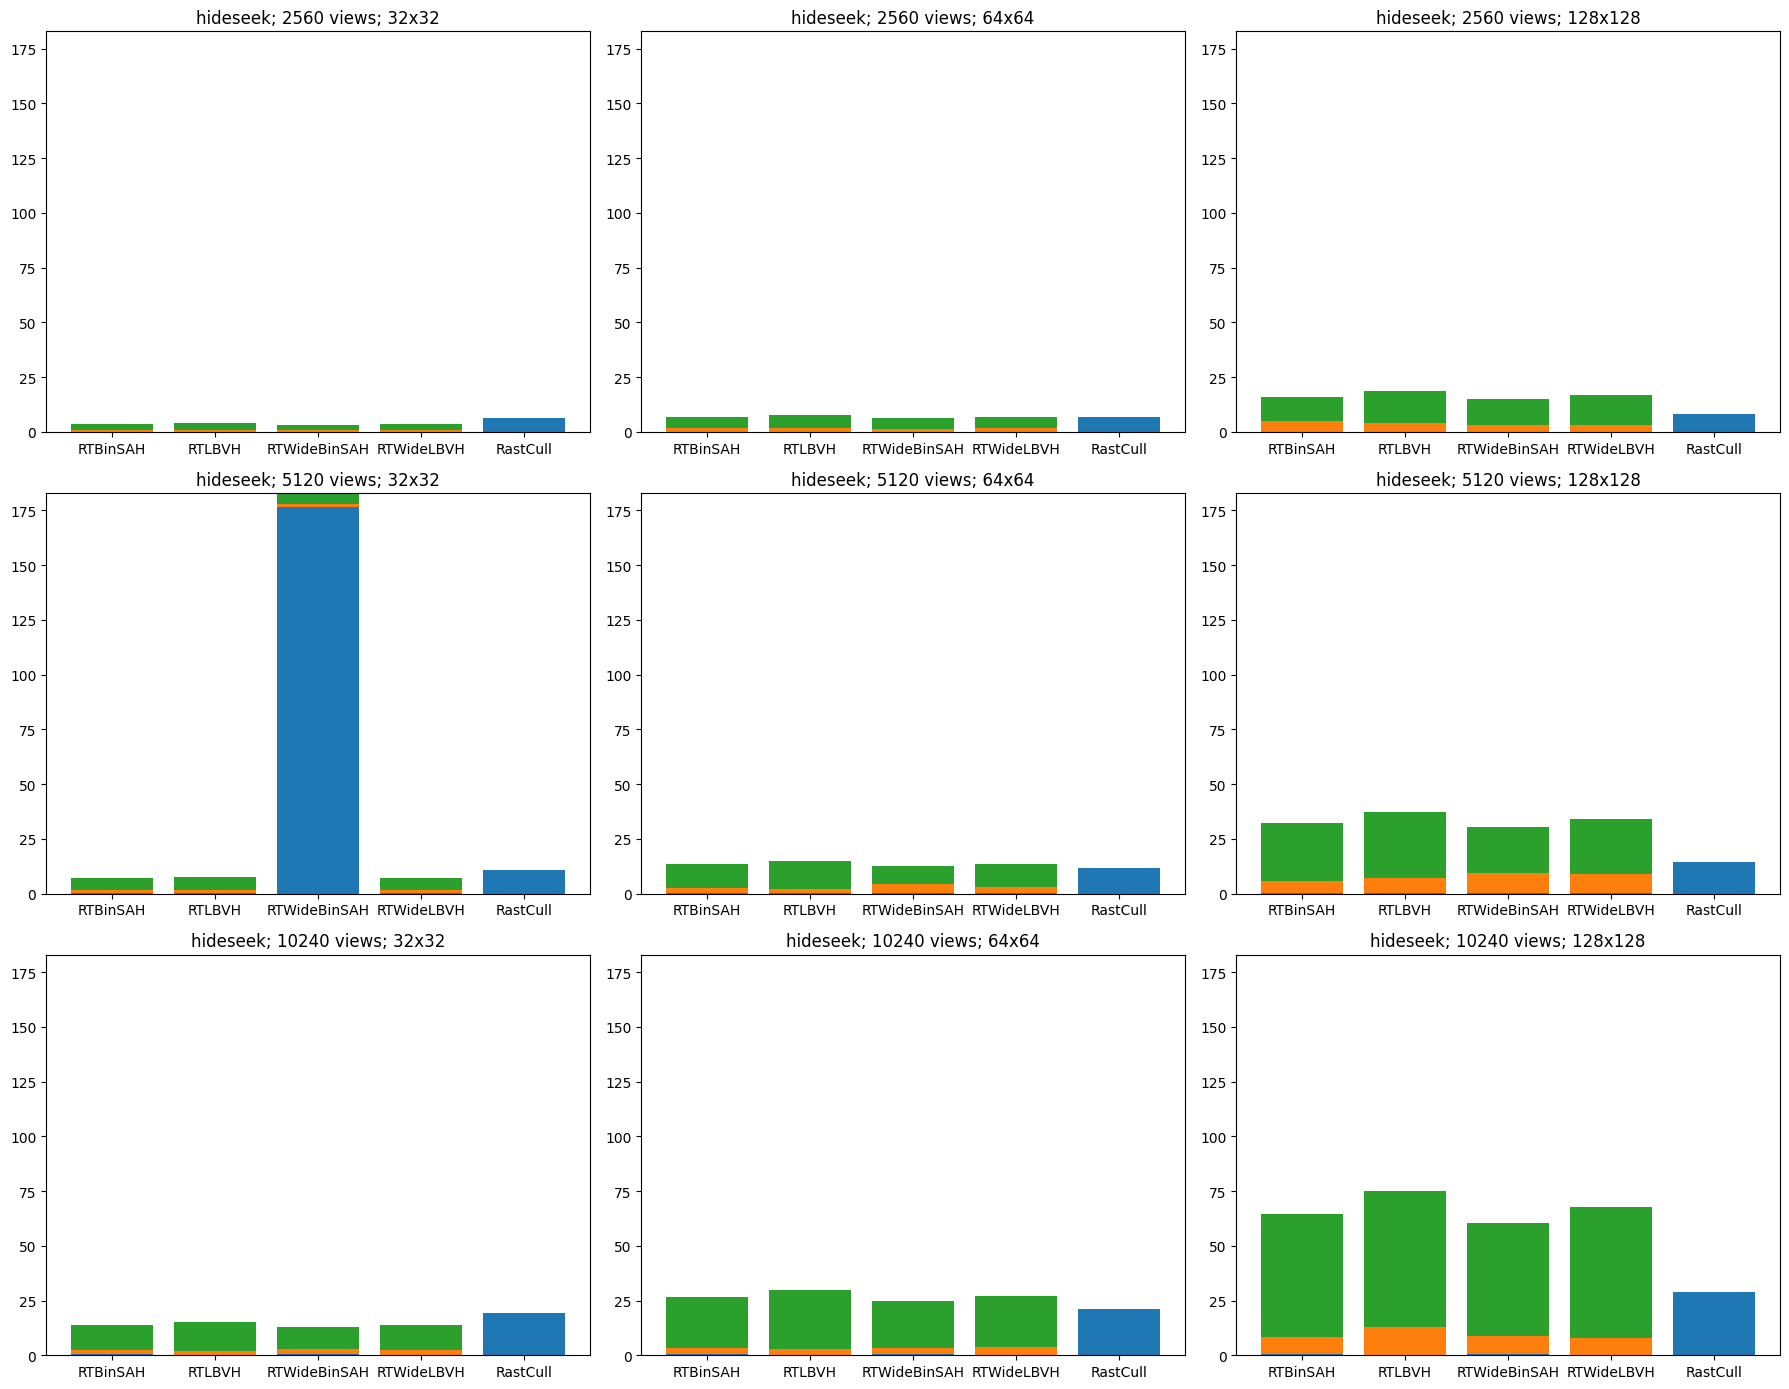

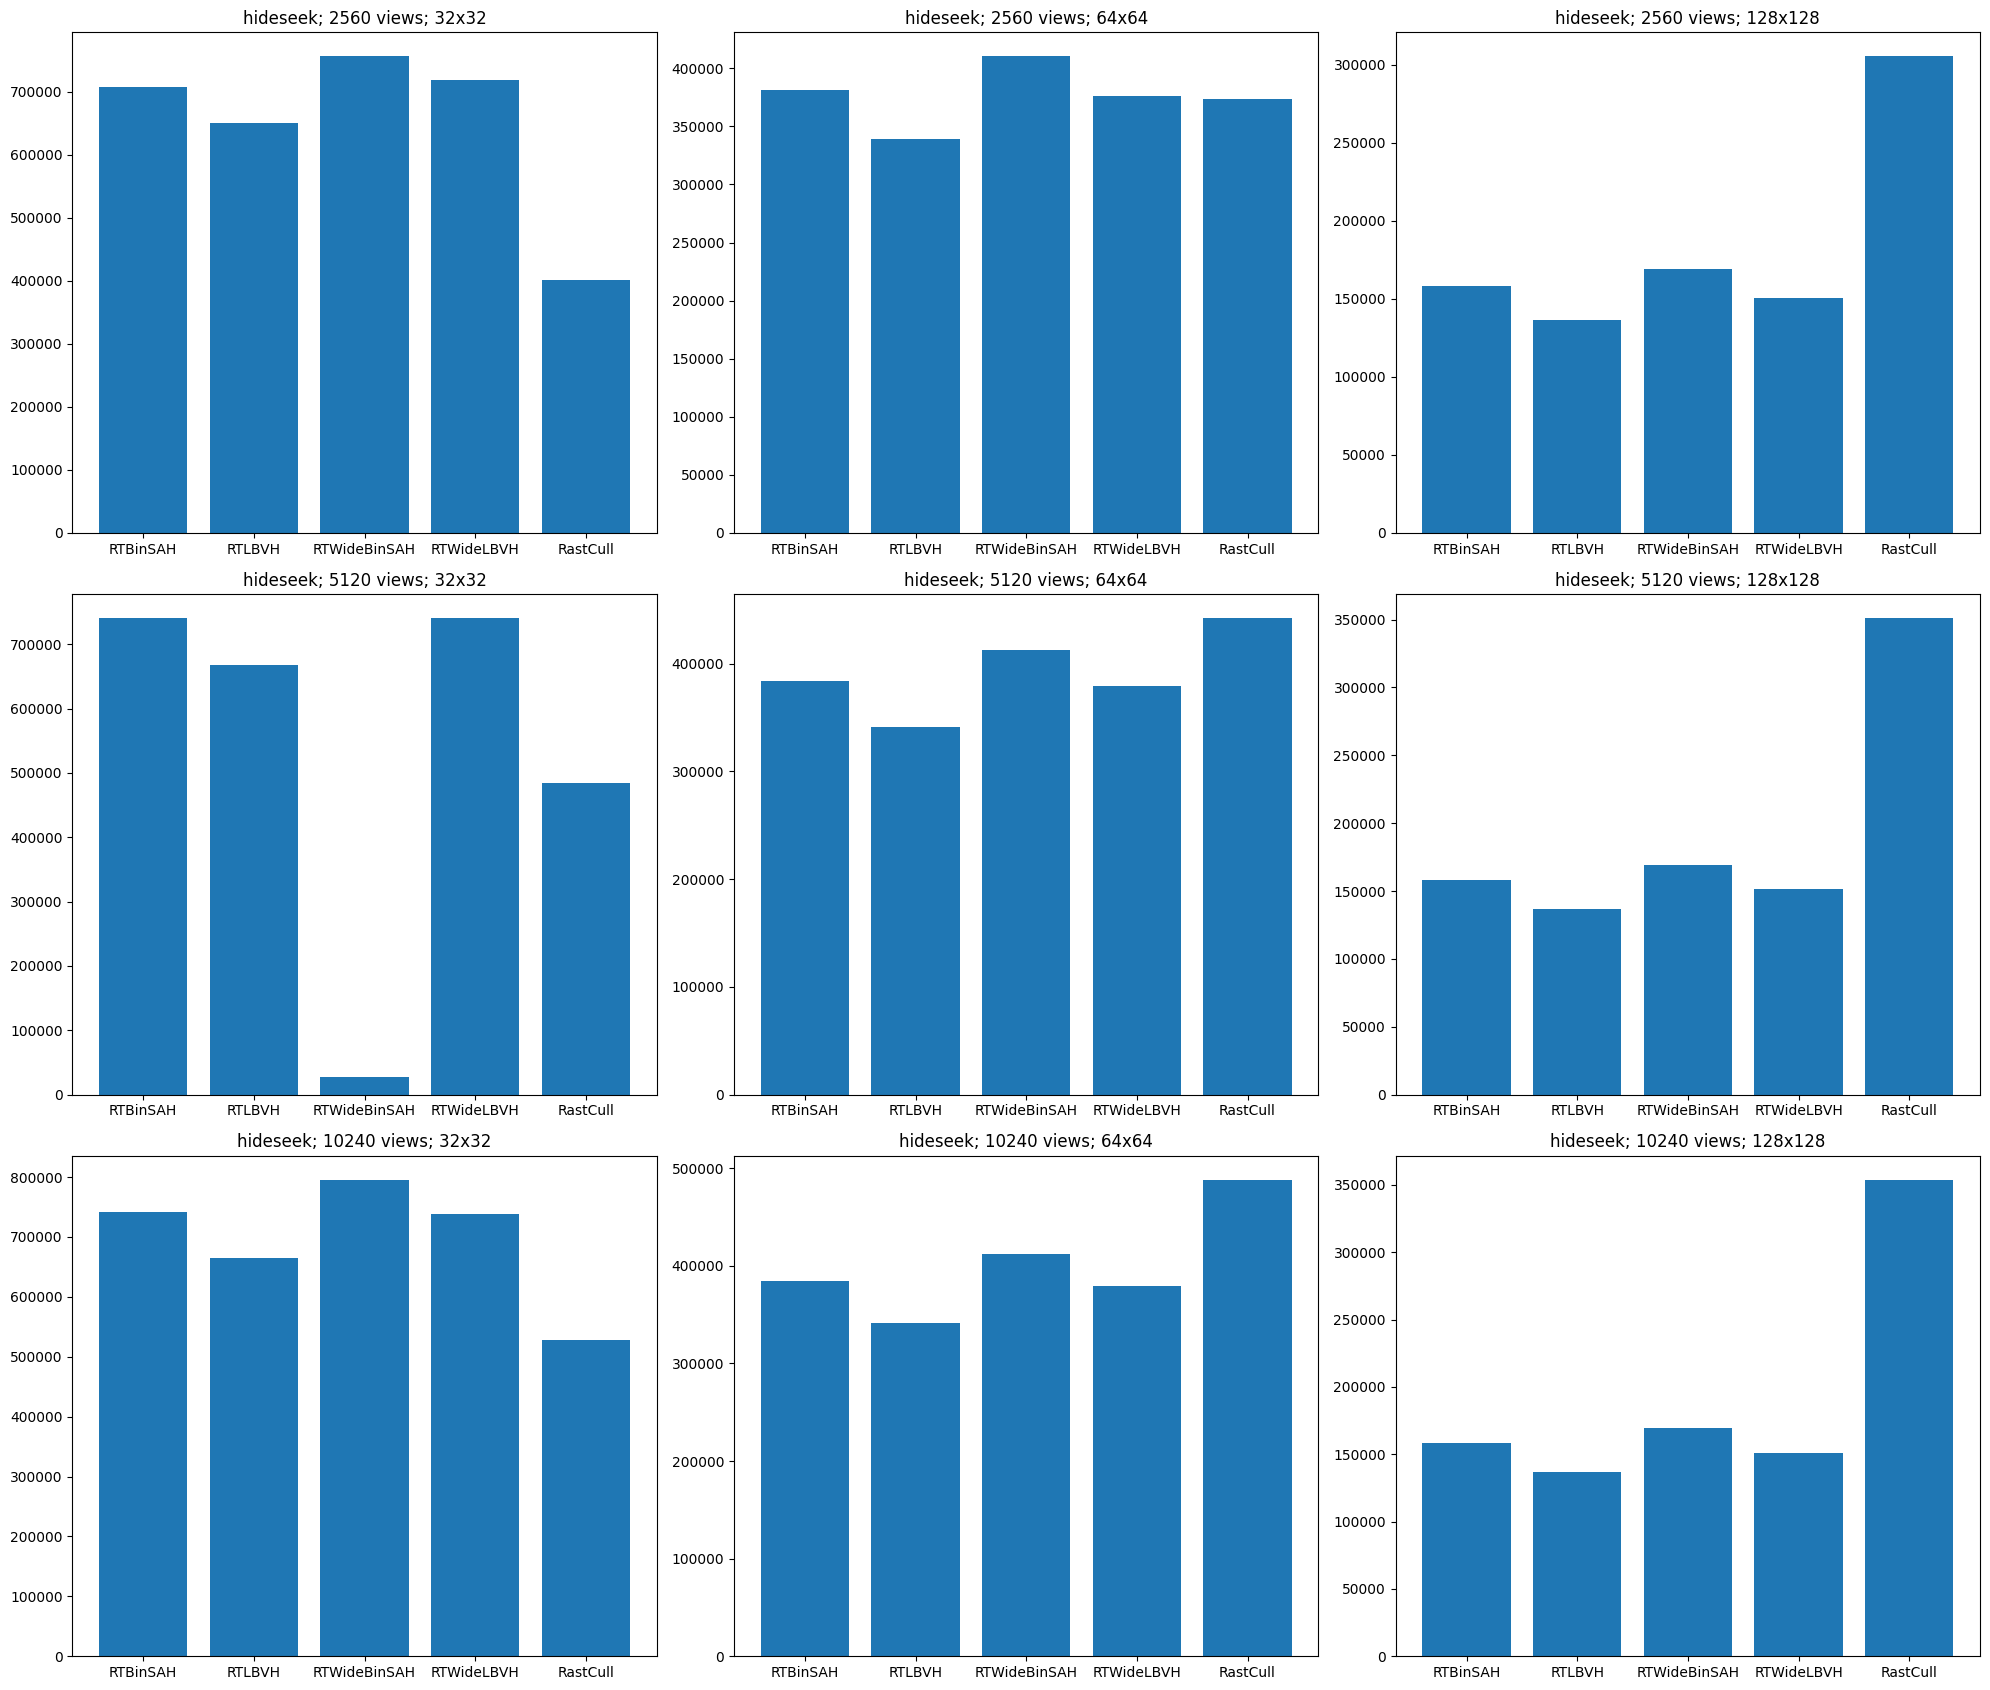

In [100]:
gen_time_graphs(hideseek_data, 5)
gen_fps_graphs(hideseek_data, 5)

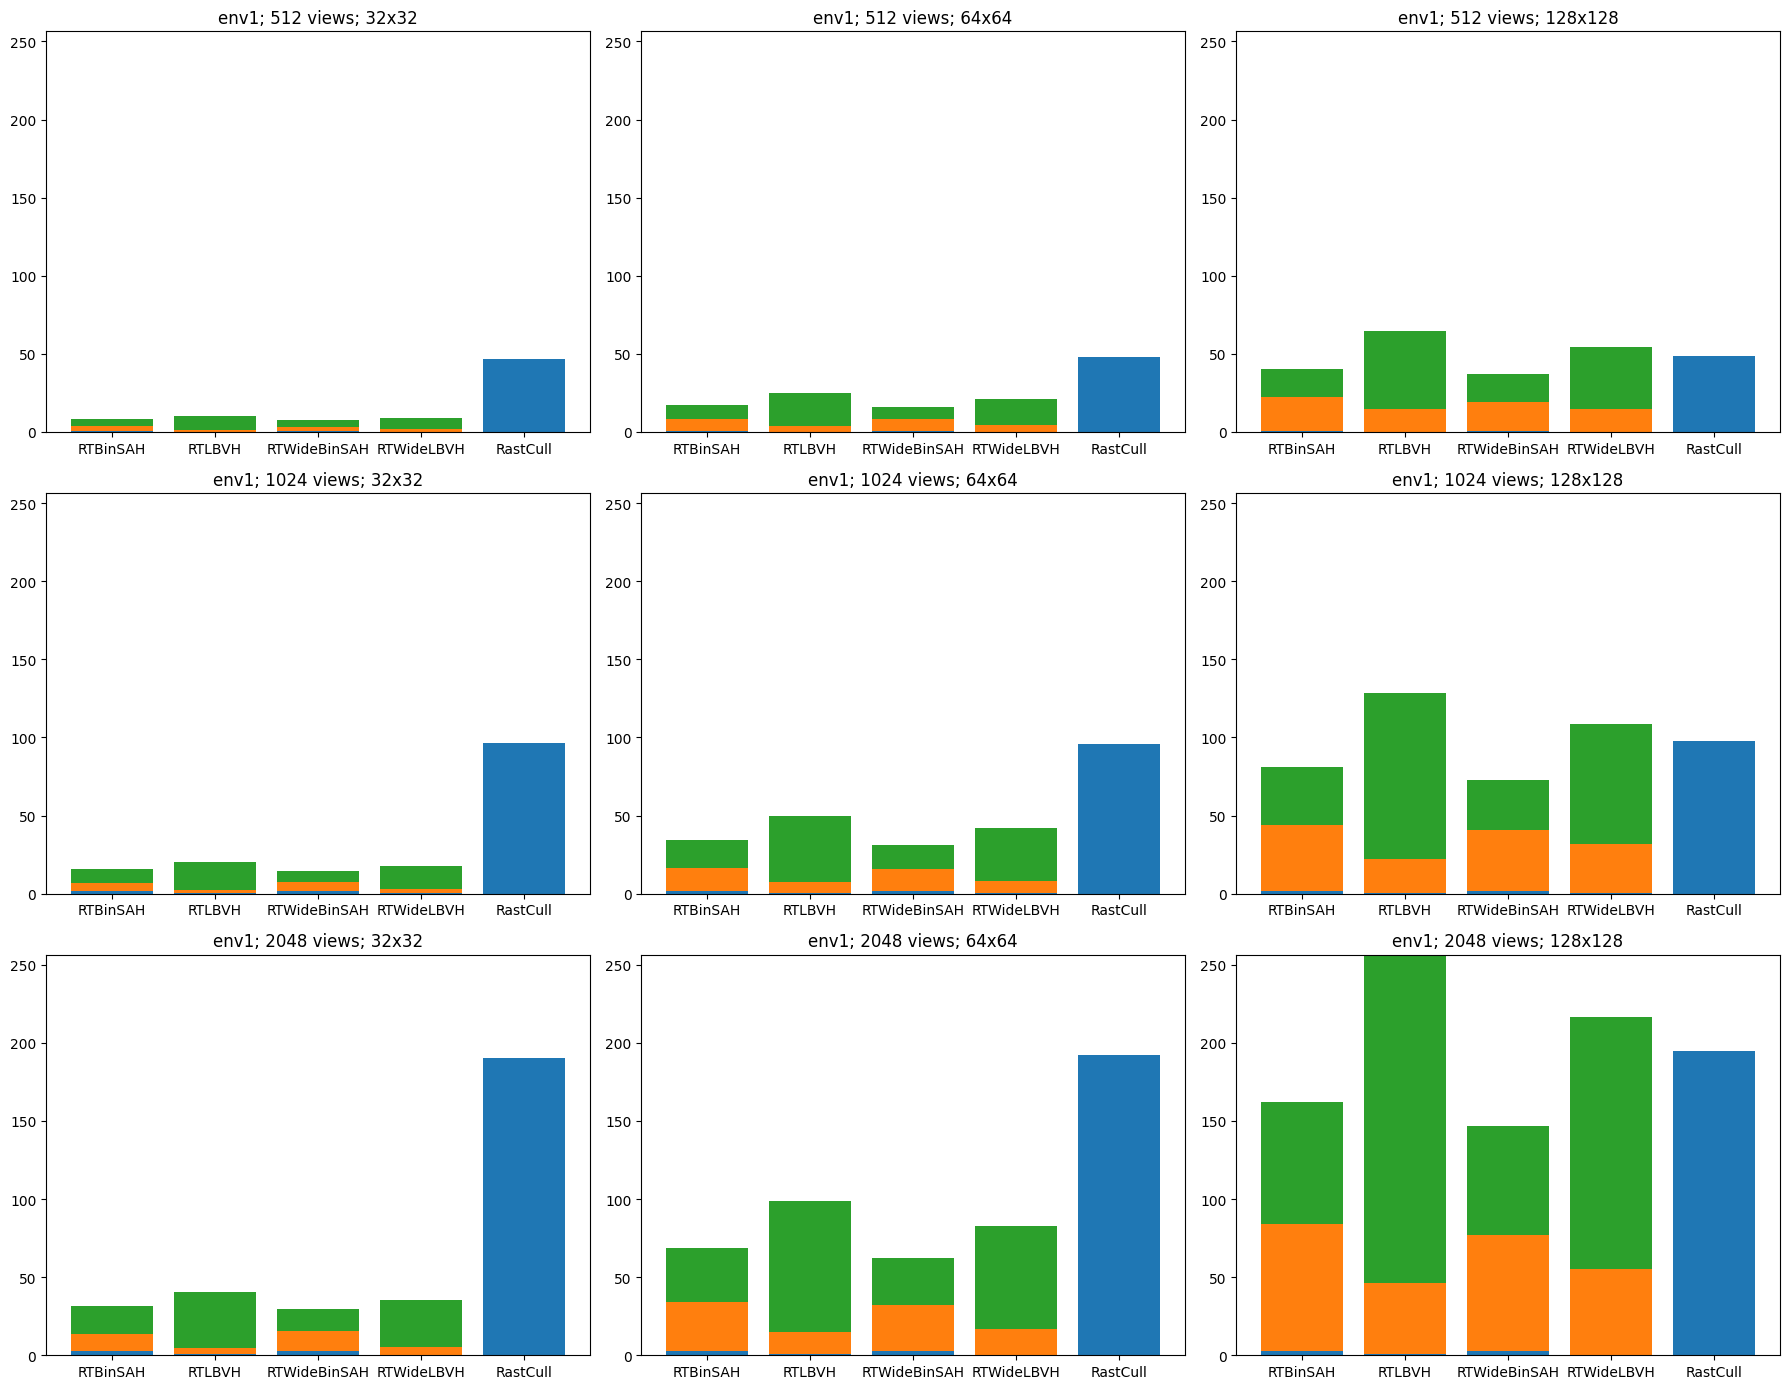

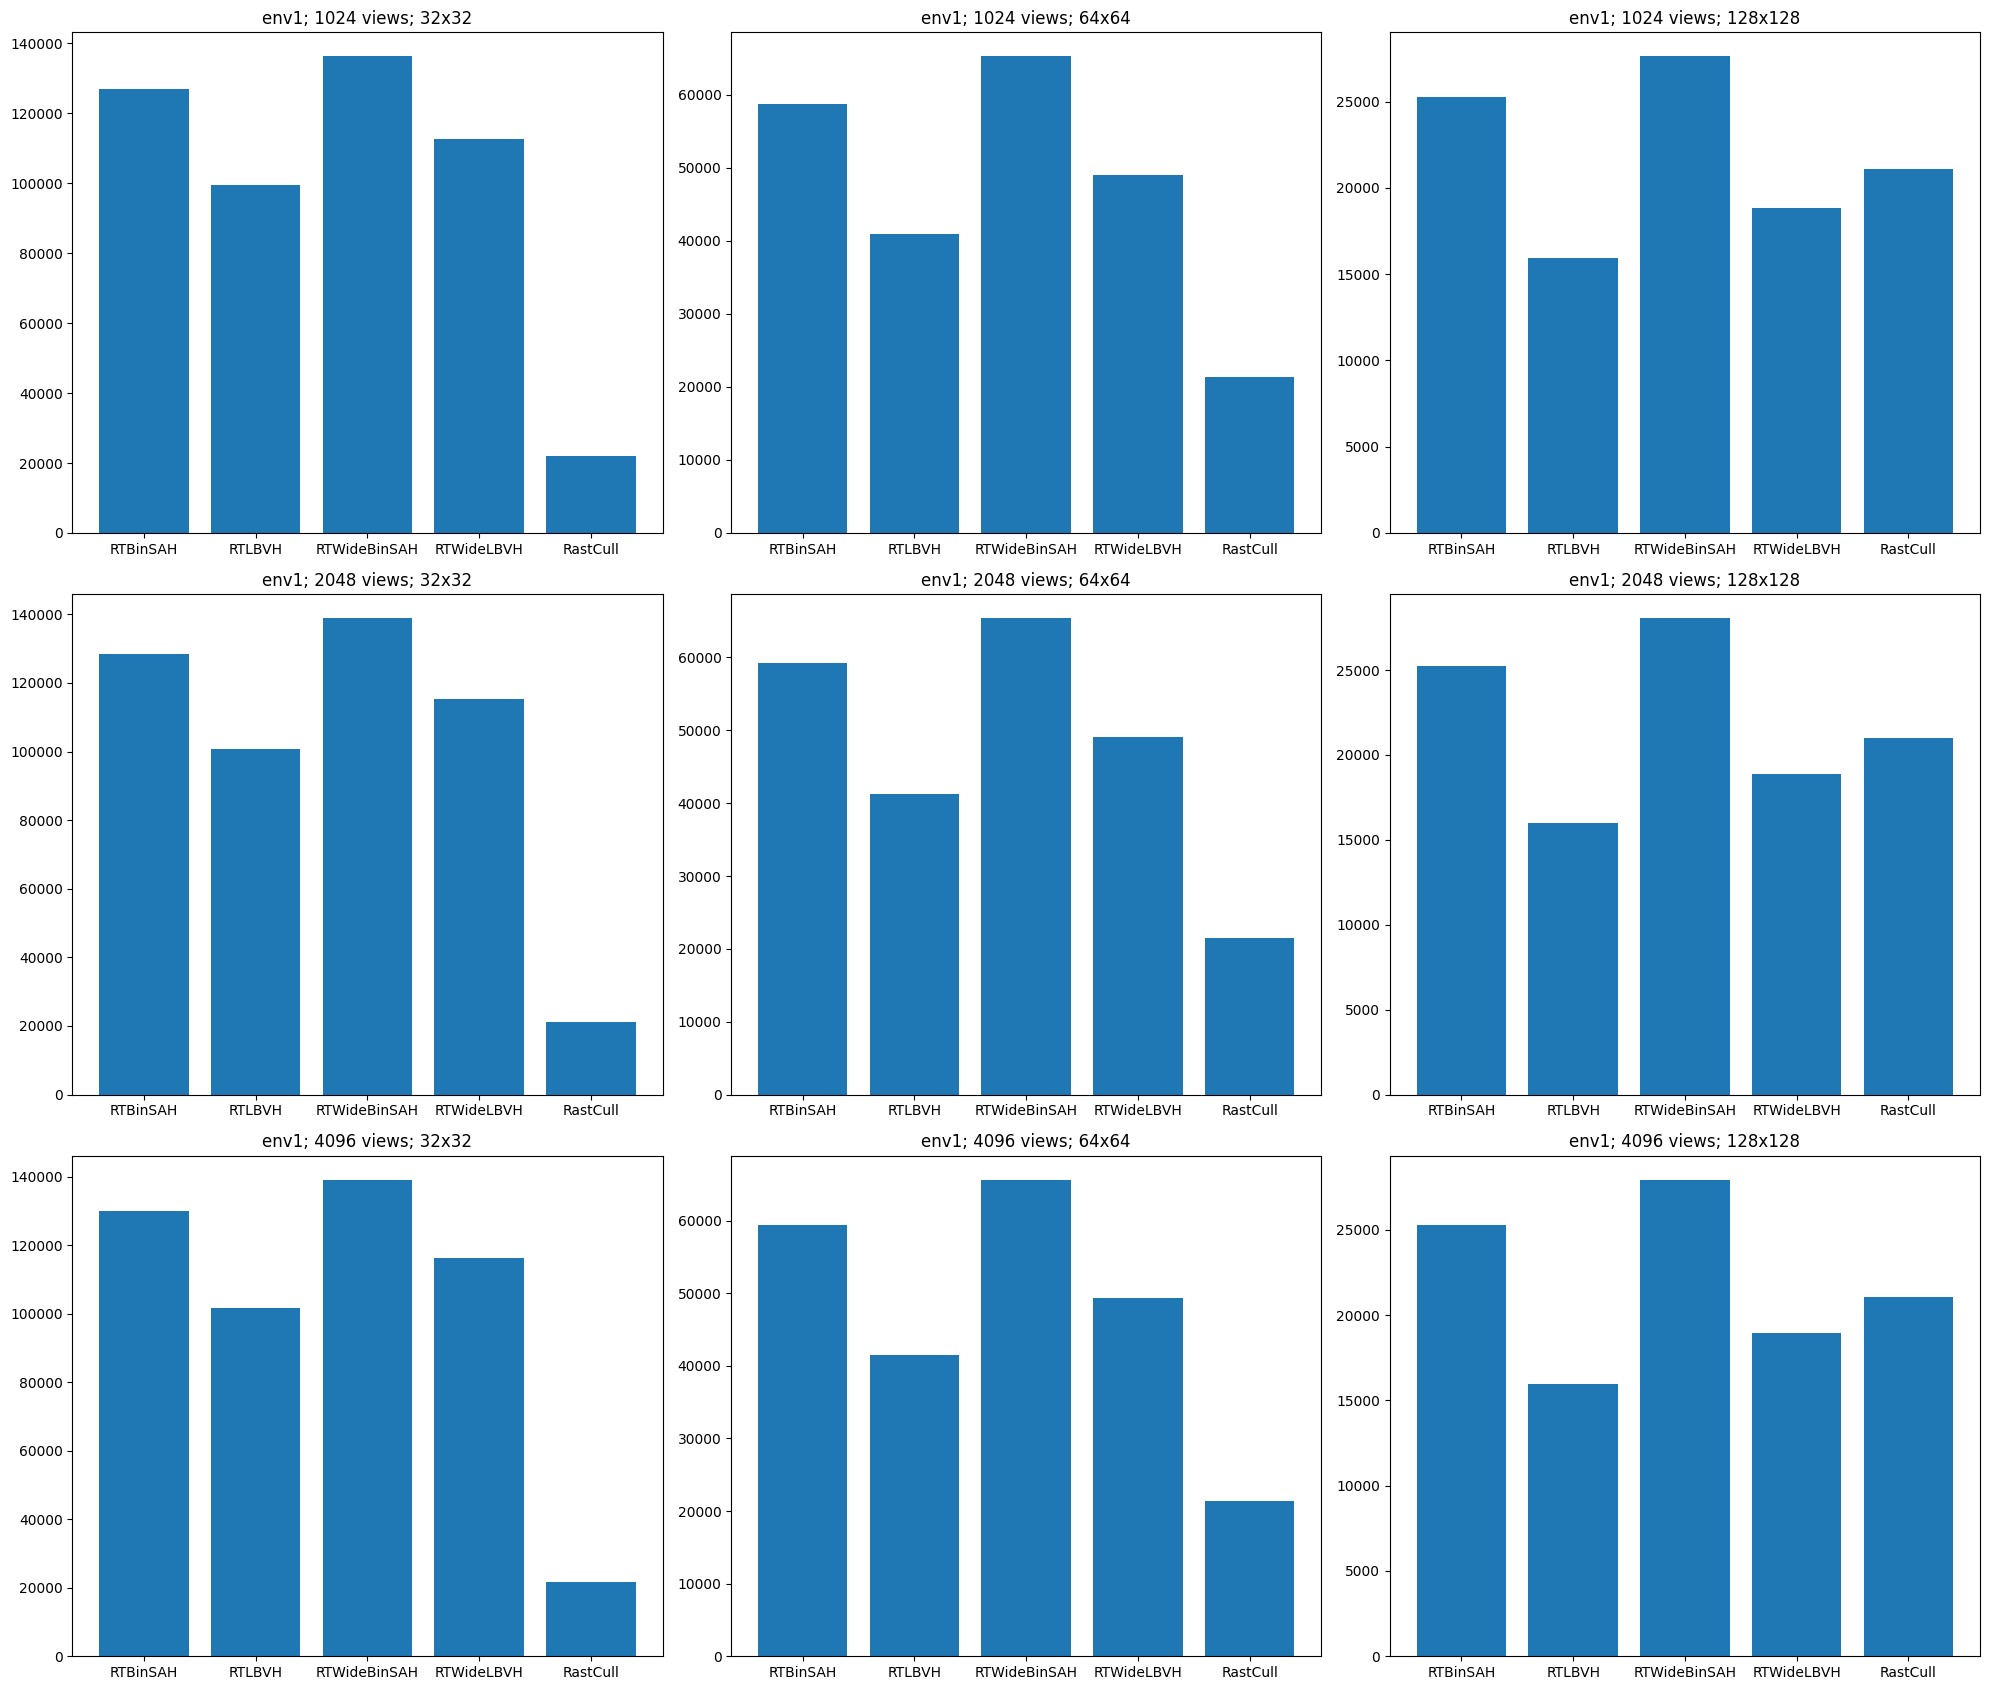

In [111]:
gen_time_graphs(env1_data, 1)
gen_fps_graphs(env1_data, 2)

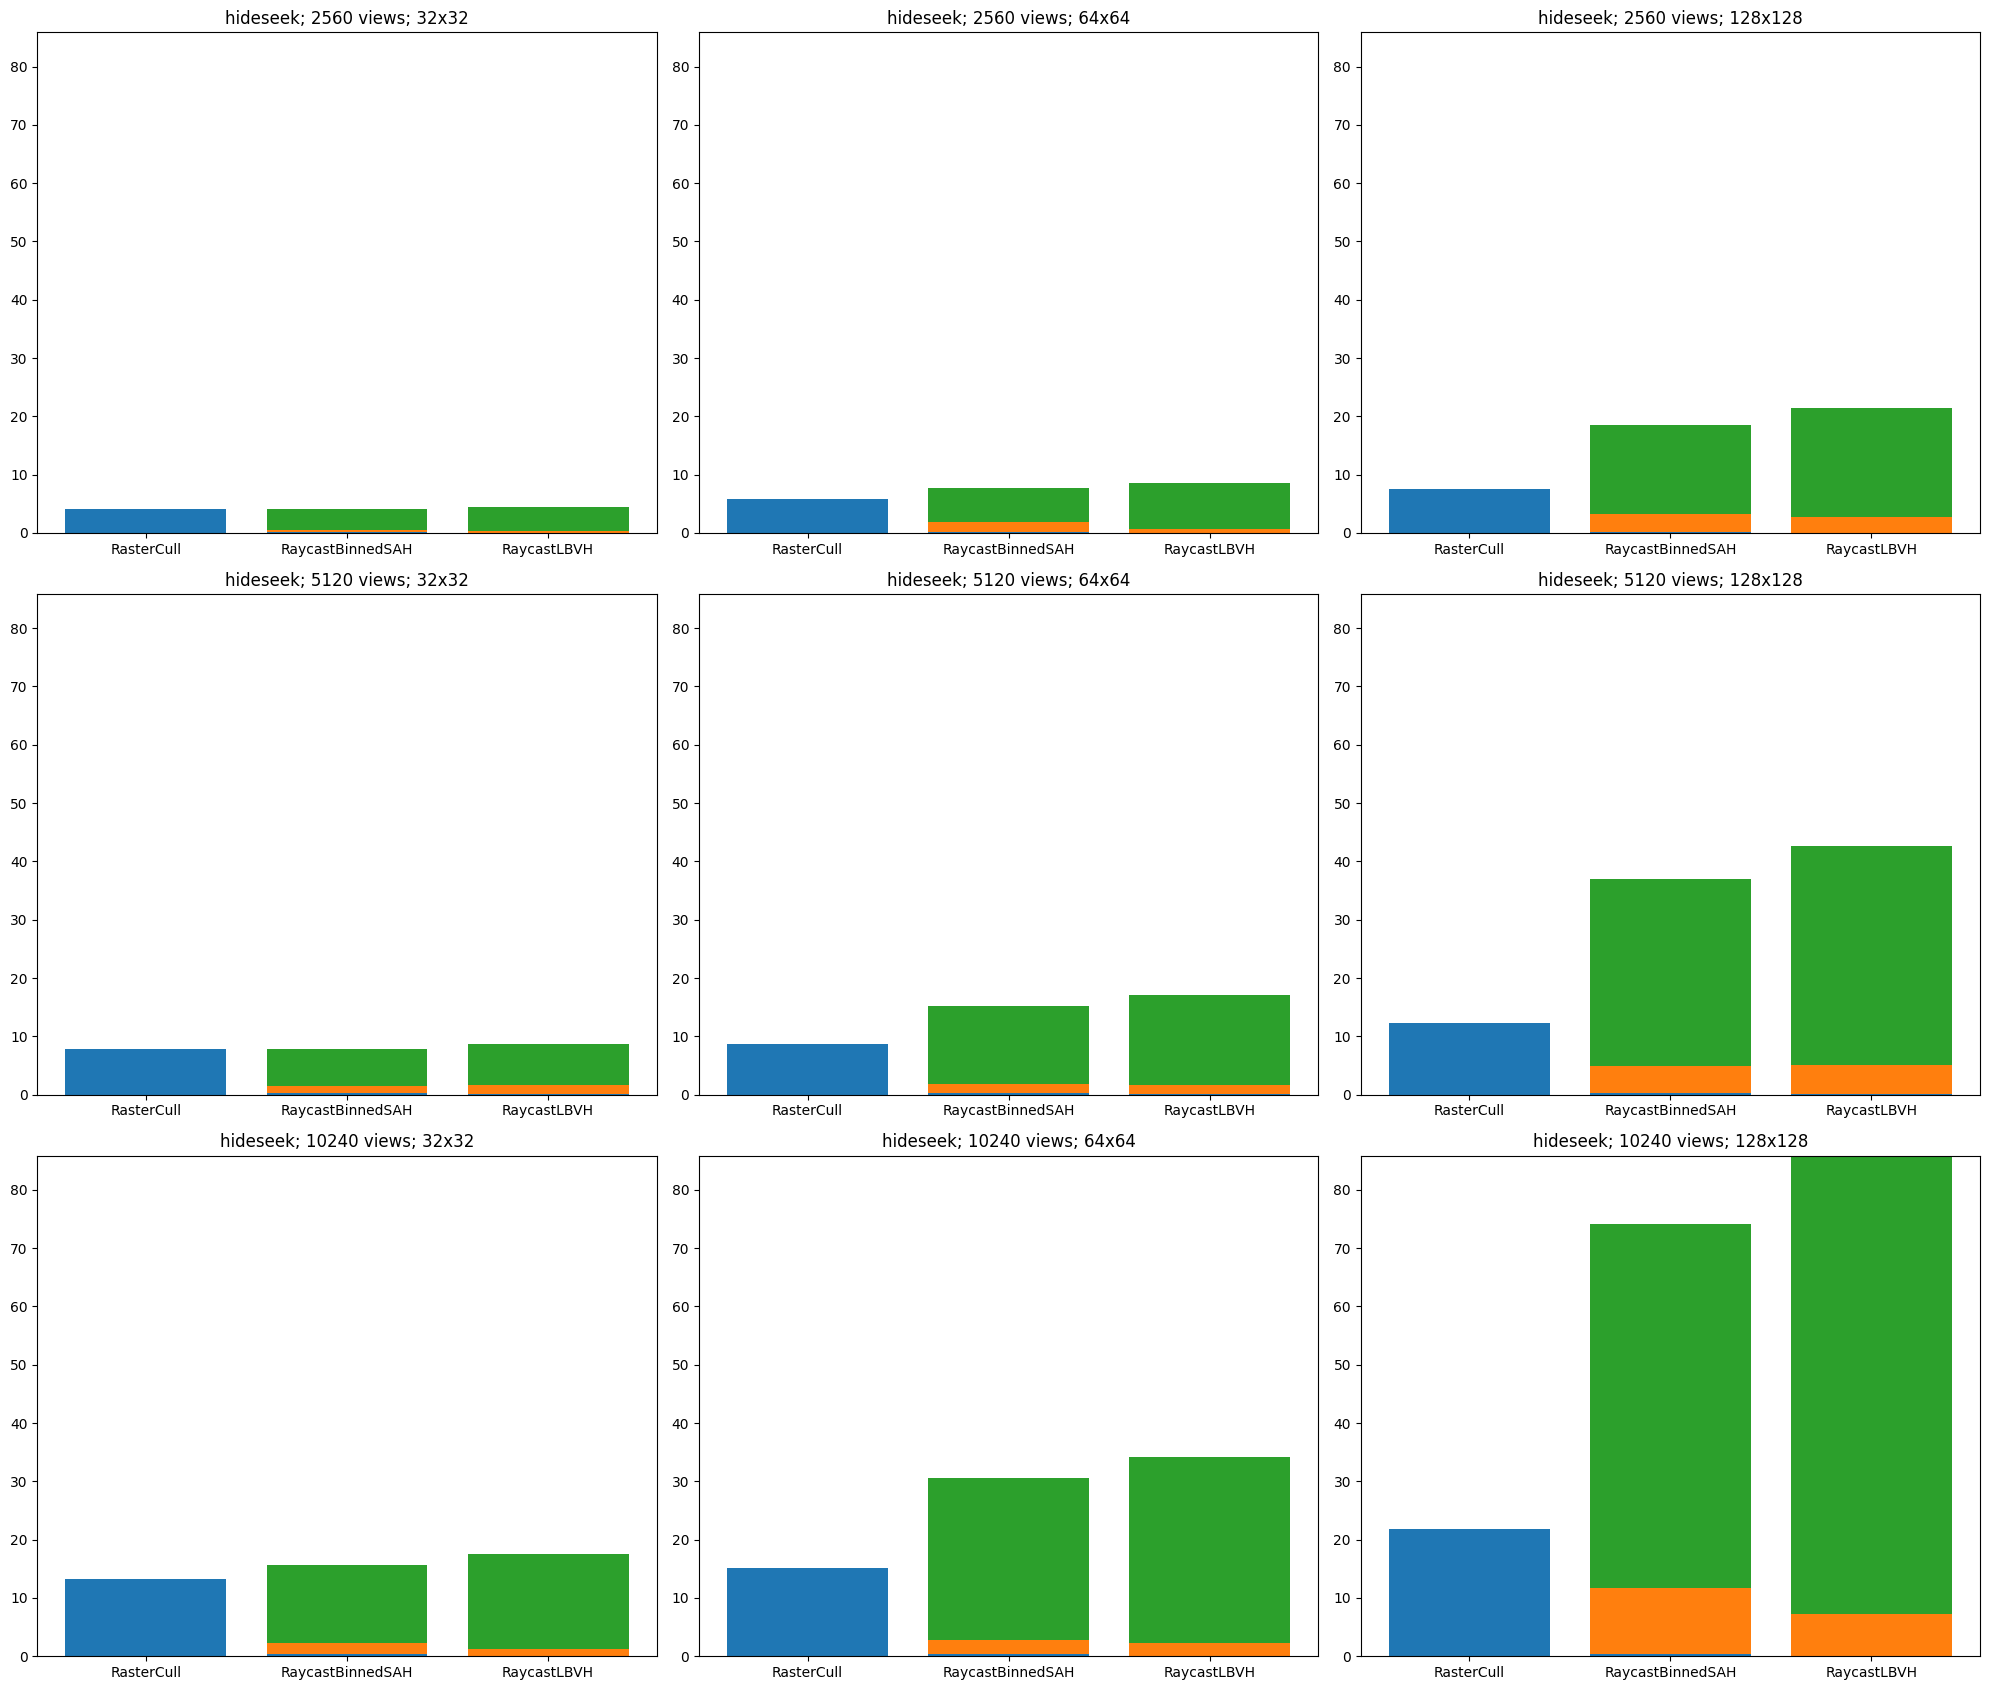

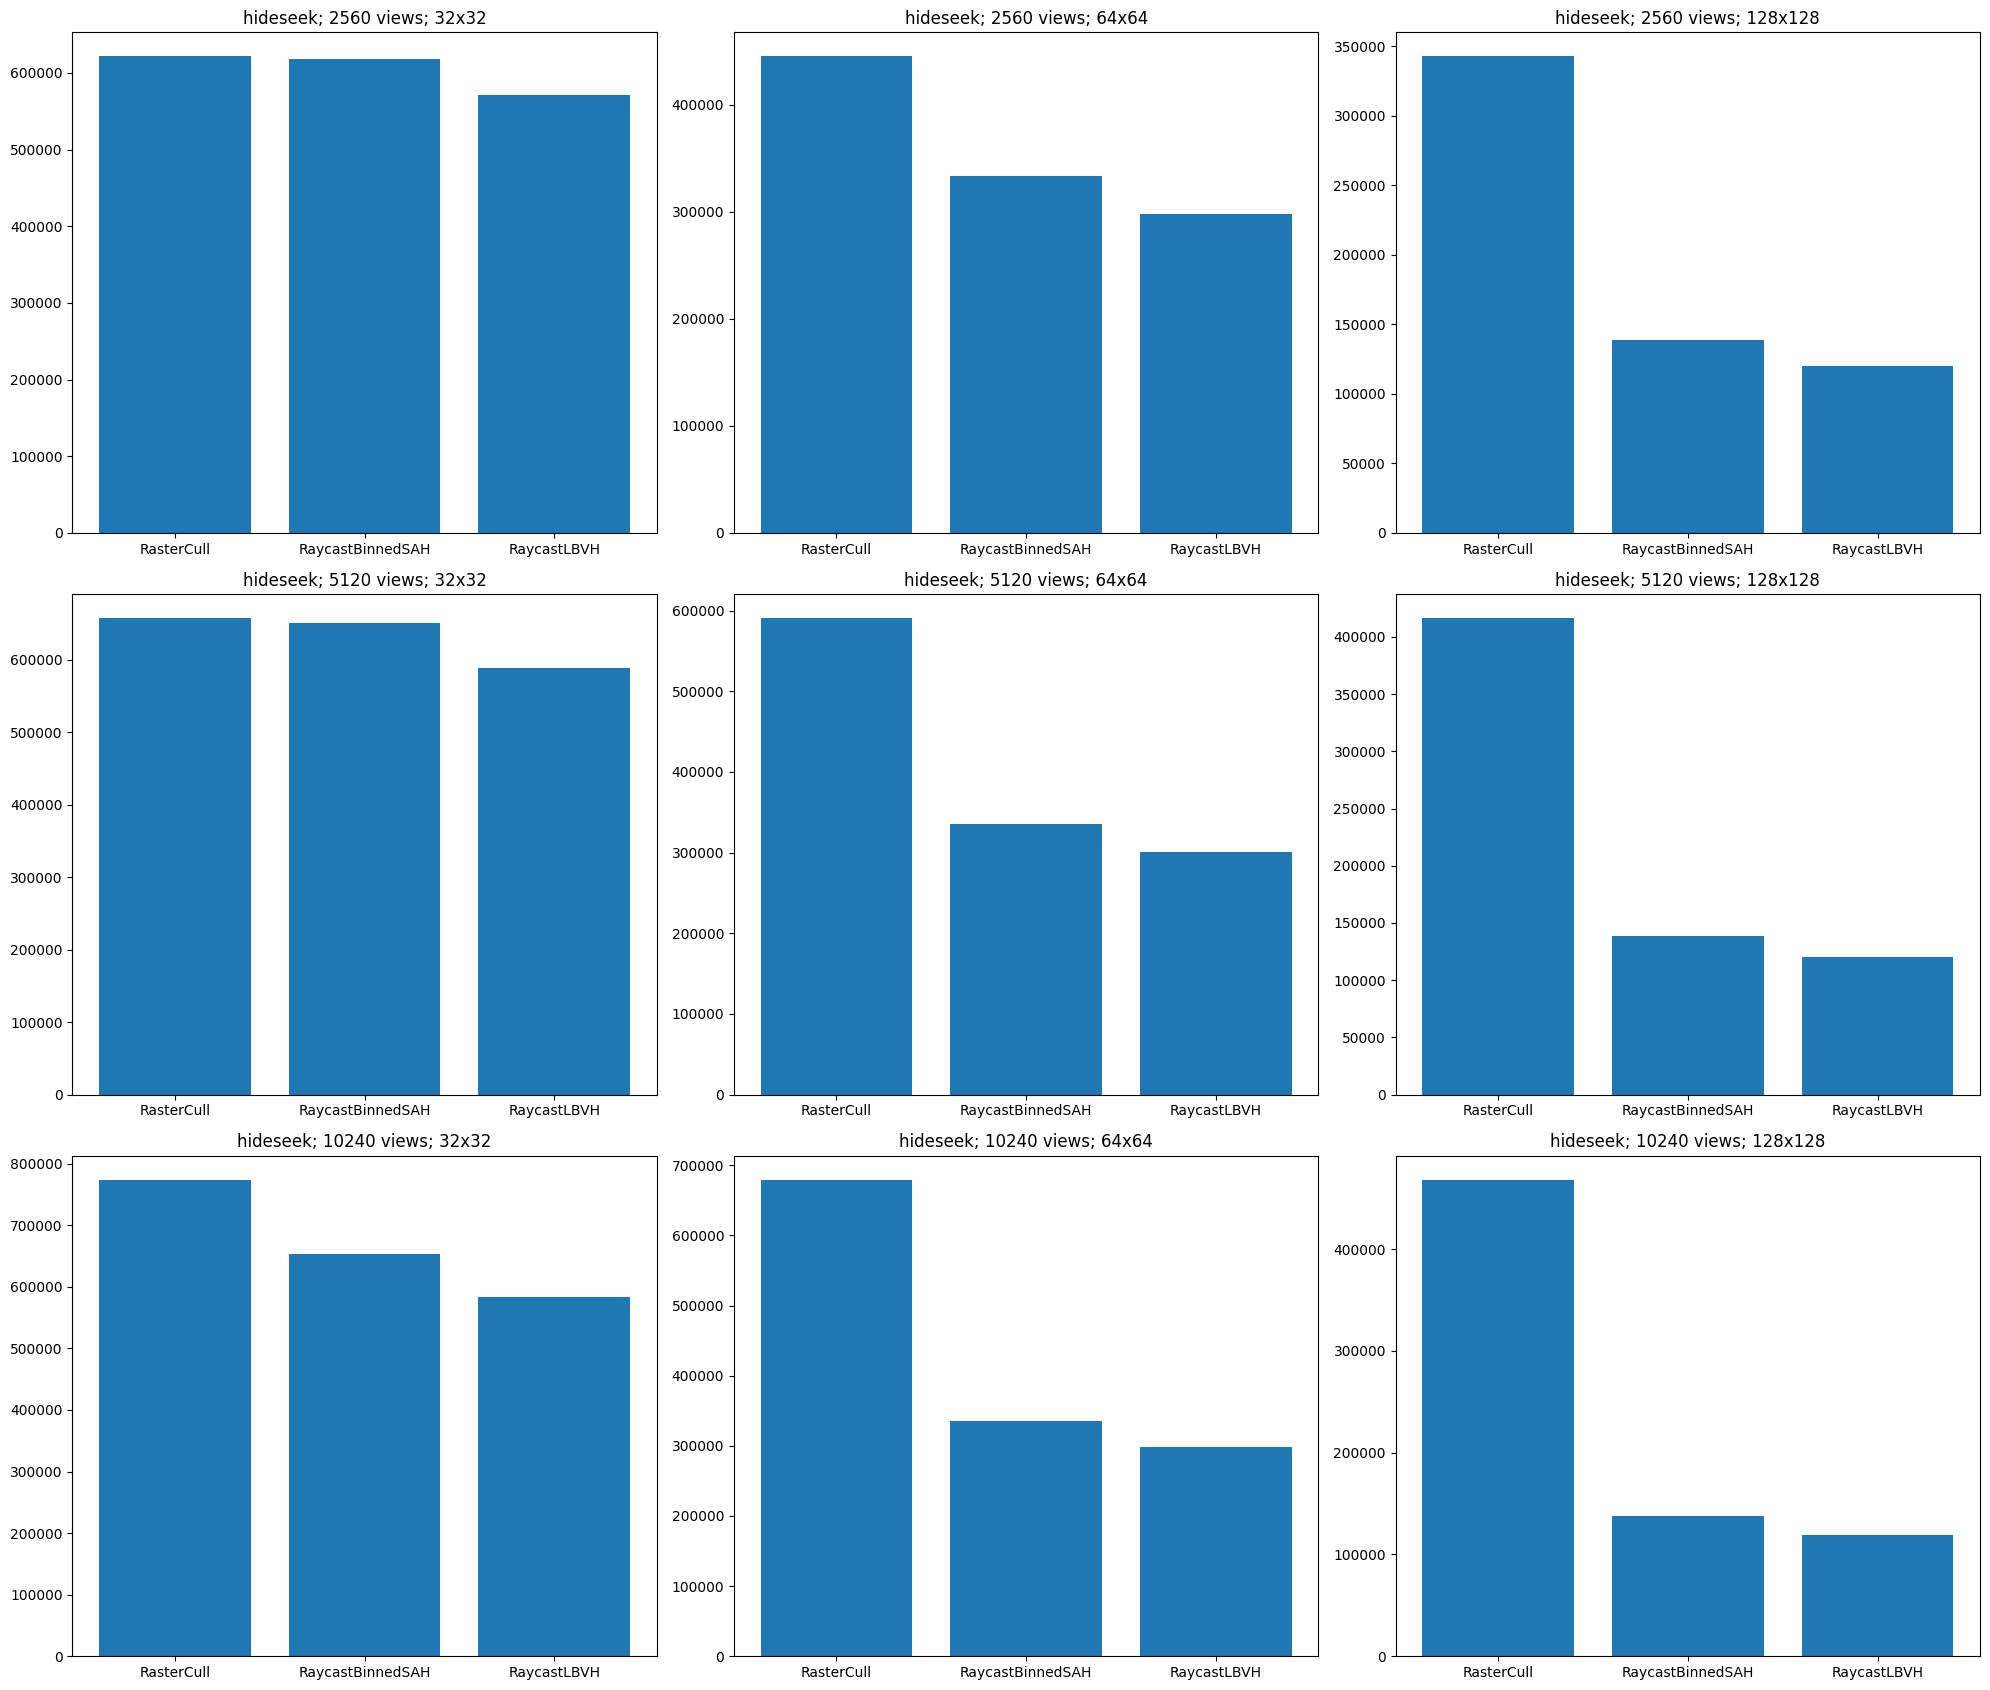

In [22]:
gen_time_graphs(env2_data, 1)
gen_fps_graphs(env2_data, 1)